reference: https://avandekleut.github.io/vae/

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))    

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
def train(autoencoder, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters())
    avg_rec_loss = {}
    for epoch in range(epochs):
        l = 0
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            rec_loss = ((x - x_hat)**2).sum() 
            loss = rec_loss + autoencoder.encoder.kl
            loss.backward()
            opt.step()
            l += rec_loss
        l /= len(data)
        avg_rec_loss[epoch] = l.item()
        print(f'Epoch {epoch+1} - avg reconstruction loss: {l}\n')
    return autoencoder, avg_rec_loss

Epoch: 1 - avg reconstruction loss: 5765.8115234375

Epoch: 2 - avg reconstruction loss: 4937.7138671875

Epoch: 3 - avg reconstruction loss: 4779.498046875

Epoch: 4 - avg reconstruction loss: 4673.4990234375

Epoch: 5 - avg reconstruction loss: 4595.4326171875

Epoch: 6 - avg reconstruction loss: 4537.37939453125

Epoch: 7 - avg reconstruction loss: 4491.34765625

Epoch: 8 - avg reconstruction loss: 4452.05517578125

Epoch: 9 - avg reconstruction loss: 4414.2431640625

Epoch: 10 - avg reconstruction loss: 4385.24853515625



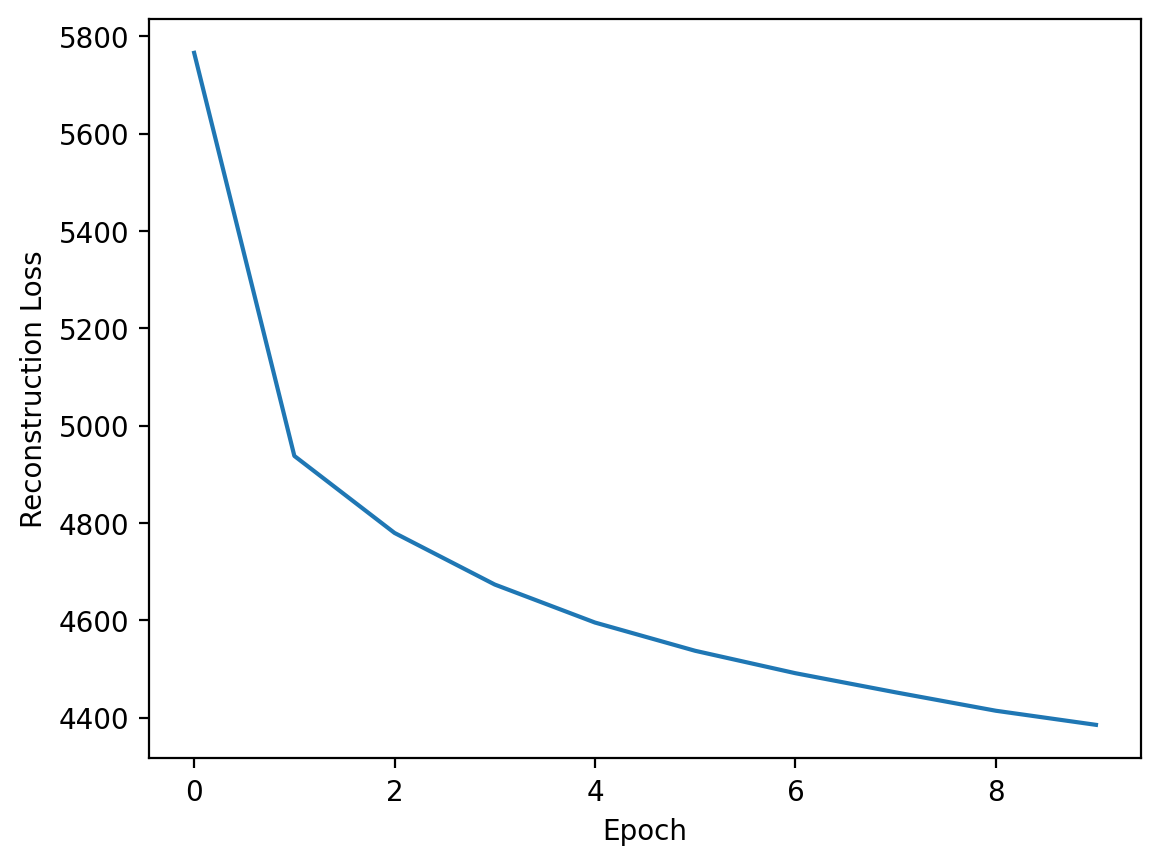

In [19]:
data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=128,
        shuffle=True)

latent_dims = 2

model = VariationalAutoencoder(latent_dims).to(device)
model, avg_rec_loss = train(model, data)

rec_err = sorted(avg_rec_loss.items())
x, y = zip(*rec_err)
plt.plot(x, y)
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss')
plt.show()

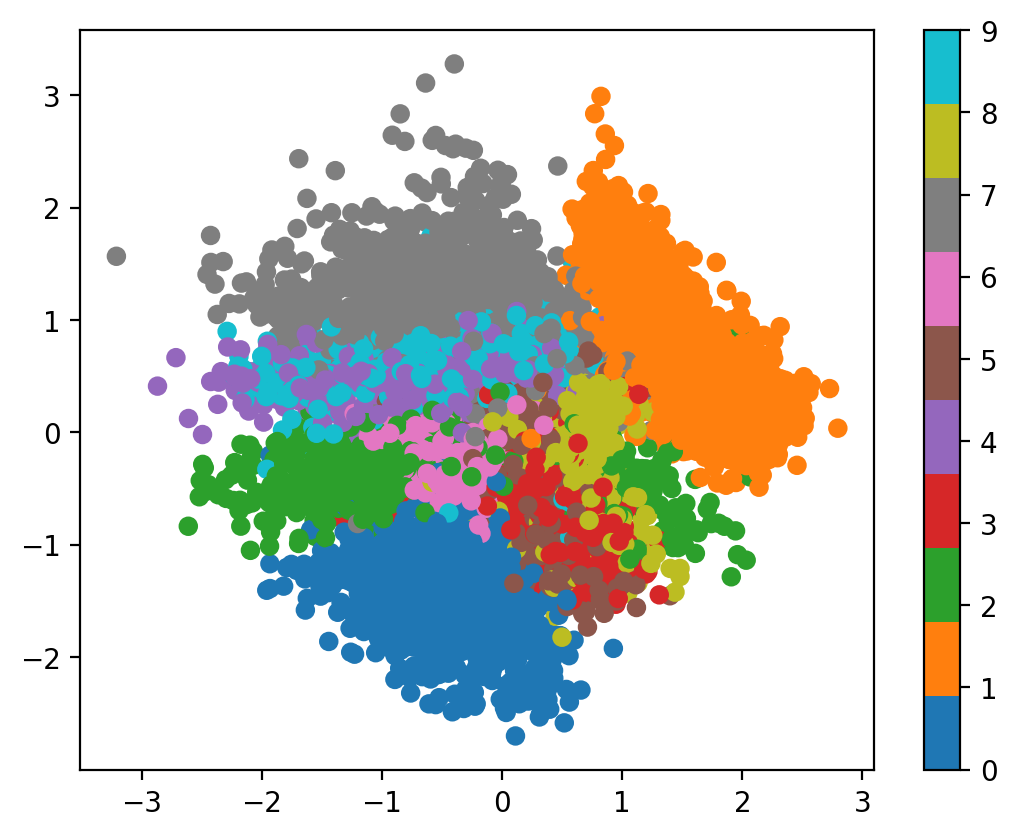

In [22]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(model, data)

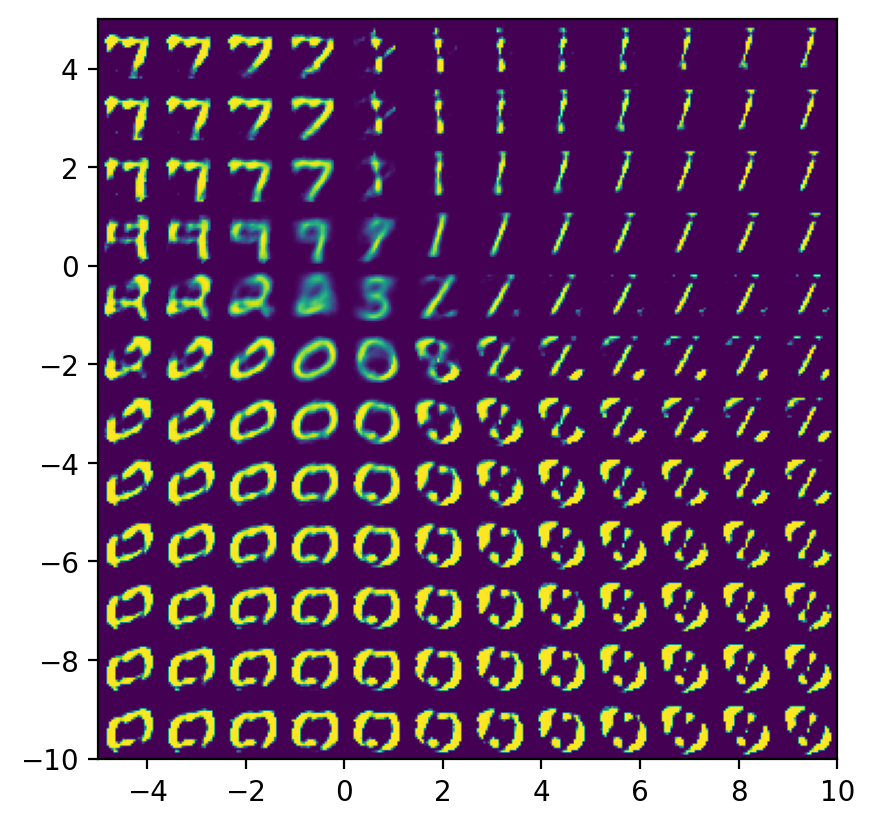

In [23]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    
def plot_reconstructed_highdim(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    # implement UMAP or tSNE
    pass

if latent_dims > 2:
    plot_reconstructed_highdim()
else:
    plot_reconstructed(model)

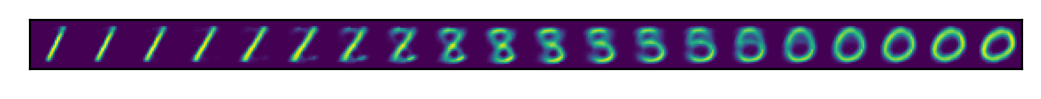

In [26]:
def interpolate(autoencoder, x_1, x_2, n=12):
    z_1 = autoencoder.encoder(x_1)
    z_2 = autoencoder.encoder(x_2)
    z = torch.stack([z_1 + (z_2 - z_1)*t for t in np.linspace(0, 1, n)])
    interpolate_list = autoencoder.decoder(z)
    interpolate_list = interpolate_list.to('cpu').detach().numpy()

    w = 28
    img = np.zeros((w, n*w))
    for i, x_hat in enumerate(interpolate_list):
        img[:, i*w:(i+1)*w] = x_hat.reshape(28, 28)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

x, y = data.__iter__().next() # hack to grab a batch
x_1 = x[y == 1][1].to(device) # find a 1
x_2 = x[y == 0][1].to(device) # find a 0

interpolate(model, x_1, x_2, n=20)